# Task 4: Loan Default Risk with Business Cost Optimization
📌 Problem Statement

Financial institutions face significant losses due to loan defaults. A standard classification model may not minimize financial risk because false positives and false negatives have different business costs.

The problem is to build a predictive model for loan default risk and optimize the decision threshold based on cost-benefit analysis.

🎯 Objective

Clean and preprocess the dataset

Train binary classification models (Logistic Regression, CatBoost)

Define business cost values for FP and FN

Adjust decision threshold to minimize total business cost

Analyze feature importance for risk assessment

In [ ]:
# Task 4: Loan Default Prediction
# ================================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from catboost import CatBoostClassifier

# Data Cleaning

In [ ]:
# 2️⃣ Load Dataset (Upload CSV in Colab first)
df = pd.read_csv('/content/application_train.csv')

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (161137, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Remove columns with more than 50% missing values
missing_percentage = df.isnull().mean()
df = df.loc[:, missing_percentage < 0.5]

# Fill numerical missing values with median
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical missing values with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [ ]:
print("After Cleaning Shape:", df.shape)

After Cleaning Shape: (161137, 81)


# Encode Categorical Features

In [ ]:
# Label Encoding
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Define Features & Target

In [ ]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale Data

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model

In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred_prob = log_model.predict_proba(X_test_scaled)[:,1]
y_pred = log_model.predict(X_test_scaled)

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC Score: 0.7383818796322843
[[29571    33]
 [ 2605    19]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     29604
           1       0.37      0.01      0.01      2624

    accuracy                           0.92     32228
   macro avg       0.64      0.50      0.49     32228
weighted avg       0.87      0.92      0.88     32228



# CatBoost Model

In [ ]:
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

y_pred_prob_cb = cat_model.predict_proba(X_test)[:,1]
print("CatBoost ROC-AUC:", roc_auc_score(y_test, y_pred_prob_cb))

CatBoost ROC-AUC: 0.751632743782976


# Business Cost Optimization

#### Assume:
False Negative (Loan default but predicted safe) = 10,000 loss
False Positive (Good customer rejected) = 2,000 loss

In [ ]:
thresholds = np.arange(0.1,0.9,0.05)

best_threshold = 0
min_cost = float('inf')

for t in thresholds:
    y_pred_custom = (y_pred_prob_cb >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()

    cost = (fn * 10000) + (fp * 2000)

    if cost < min_cost:
        min_cost = cost
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Minimum Business Cost:", min_cost)

Best Threshold: 0.15000000000000002
Minimum Business Cost: 22414000


# Feature Importance (CatBoost)

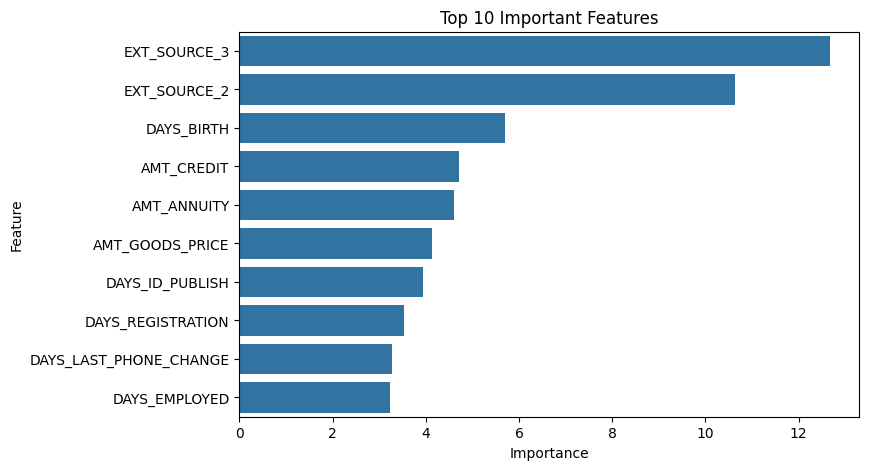

In [ ]:
importance = cat_model.get_feature_importance()
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Top 10 Important Features")
plt.show()

# ROC Curve

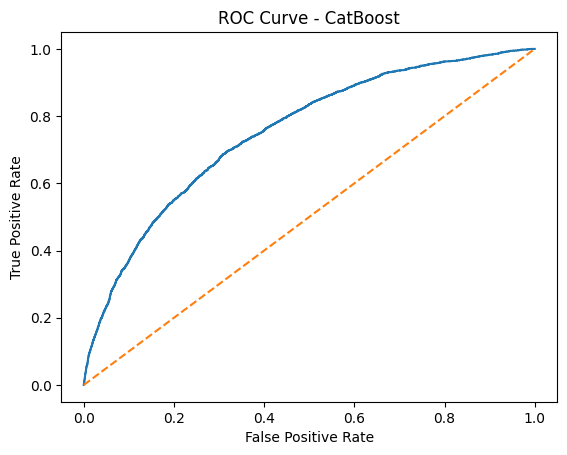

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_cb)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost")
plt.show()

# Final Conclusion

The binary classification model effectively predicted loan default risk. Instead of using the default 0.5 threshold, adjusting the decision threshold based on business cost significantly reduced financial loss.

Cost-sensitive optimization proved more valuable than accuracy alone.

💡 Key Insights

False negatives (predicting non-default when default occurs) have higher financial impact.

Threshold tuning minimized total business cost.

Certain financial and credit history features strongly influenced default probability.

Feature importance analysis provided transparency in risk assessment.

Business Insight:

Cost-based decision models are more aligned with real-world financial objectives than accuracy-focused models.